# Mt. Rainier glaciers example
This exercise focuses on working with [GIS raster data](https://docs.qgis.org/3.4/en/docs/gentle_gis_introduction/raster_data.html). It is based on a [GeoHackWeek tutorial](https://github.com/geohackweek/tutorial_contents/blob/master/raster/notebooks/rainier_dem_example.ipynb). We will use the `rasterio` and `rasterstats` libraries, along with `numpy` and `matplotlib` to look changes in the surface elevations of mapped glaciers since 1970.

#### Key takeaways:
* raster formats such as GeoTiff map array data on a regular grid using a simple transform (offset, rotation and pixel size).
* working with raster data in python is inherently a little difficult, because the raster data model is designed to work efficiently with large datasets on disk (without loading whole thing into memory). Other available tools, such as the [gdal commandline tools](https://gdal.org/programs/index.html) or ArcPy macros, tend to stay in this paradigm by taking files as input to fuctions that write files as output.
* conversely, when we work with arrays in-memory with `numpy`, we typically think it terms of rows and columns
* **the main idea is to**   
    1) use `rasterio` (or another tool) to handle the files and any transformations needed to align the data. As we'll see below, most of these operations aren't especially intuitive or easy to remember. Thankfully, there are recipes available online that are easy to copy for performing common tasks. The [rasterio manual](https://rasterio.readthedocs.io/en/stable/) is a great place to start.  
    2) once the data are in numpy, use `numpy` and other tools in the scientific python stack (e.g. `scipy`) to do the computations  

#### Datasets:
* 3 Digital Elevation Models (DEMs) of Mt. Rainier elevations in 1970, 2008 and 2015; each on a different grid.
* shapefile of glacier extents

#### Operations:
* read and write rasters to/from `numpy` arrays
* plotting raster data
* warping (resampling) raster data to different grids
* reprojecting raster data to different coordinate reference systems
* getting raster data at discrete points
* zonal statistics
* mapping vector features onto rasters ("rasterizing")

#### References:
* The [rasterio manual](https://rasterio.readthedocs.io/en/stable/)
* The [GeoHackWeek tutorials](https://geohackweek.github.io/raster/) for more information on working with raster data in the python

In [1]:
import os
import numpy as np
import geopandas as gp
import rasterio
from rasterio.plot import show
from rasterio import features
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# for elevation hillshade if we want to use it
ls = LightSource(azdeg=315, altdeg=45)

### input data

In [2]:
dem_1970_fn = 'data/gis/19700901_ned1_2003_adj_warp.tif'
dem_2008_fn = 'data/gis/20080901_rainierlidar_30m-adj.tif'
dem_2015_fn = 'data/gis/20150818_rainier_summer-tile-30.tif'

glaciers_shapefile = 'data/gis/rgi60_glacierpoly_rainier.shp'

input_rasters = {1970: dem_1970_fn, 
                 2008: dem_2008_fn, 
                 2015: dem_2015_fn
                }

### quickly viewing a raster

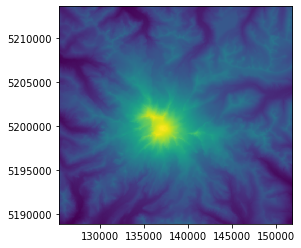

In [3]:
with rasterio.open(input_rasters[1970]) as src:
    show(src)

### get raster values at point locations
if we have a list of (x, y) tuples, we can unpack it into two lists of x and y values:
`zip(*points)`  

`zip(*points)` returns a tuple of the two lists, so if we do the unpacking in a function call (e.g. `src.index(*zip(*points))`), we need to add a leading `*` to unpack the tuple into two separate arguments

In [4]:
help(src.index)

Help on method index in module rasterio.transform:

index(x, y, op=<built-in function floor>, precision=None) method of rasterio.io.DatasetReader instance
    Returns the (row, col) index of the pixel containing (x, y) given a
    coordinate reference system.
    
    Use an epsilon, magnitude determined by the precision parameter
    and sign determined by the op function:
        positive for floor, negative for ceil.
    
    Parameters
    ----------
    x : float
        x value in coordinate reference system
    y : float
        y value in coordinate reference system
    op : function, optional (default: math.floor)
        Function to convert fractional pixels to whole numbers (floor,
        ceiling, round)
    precision : int, optional (default: None)
        Decimal places of precision in indexing, as in `round()`.
    
    Returns
    -------
    tuple
        (row index, col index)



In [5]:
points = [(594508.70, 5189550.08), # summit, in utm zone 10N
          (596702, 5187675) # camp muir
         ]

with rasterio.open(input_rasters[2015]) as src:       
        meta = src.meta
        data = src.read(1)
        i, j = src.index(*zip(*points))
data[i, j]

array([4361.6406, 3055.5547], dtype=float32)

### viewing the 3 rasters side by side as subplots
The data are all on different grids with varying extents and projections. We see what these are by fetching the metadata dictionary (`src.meta` attribute) for each one.

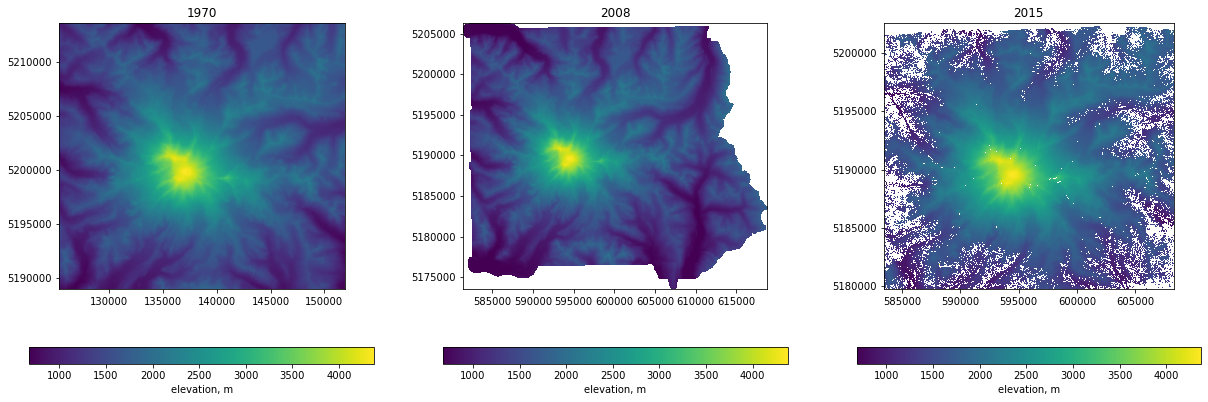

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

meta = {}
for i, (year, f) in enumerate(input_rasters.items()):
    with rasterio.open(f) as src:
        
        # get the metadata
        meta[year] = src.meta
        
        # plot the data
        if i == 0:
            data = src.read(1)
            vmin, vmax = data.min(), data.max()
        ax=axes.flat[i]
        show(src, ax=ax, vmin=vmin, vmax=vmax)
        ax.set_title(year)
        plt.colorbar(ax.images[0], ax=ax, 
                     orientation='horizontal', label='elevation, m')

The different grids are described in the metadata:

In [7]:
meta

{1970: {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -9999.0,
  'width': 884,
  'height': 824,
  'count': 1,
  'crs': CRS.from_epsg(26911),
  'transform': Affine(30.0, 0.0, 125349.01533479267,
         0.0, -30.0, 5213641.54503958)},
 2008: {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -9999.0,
  'width': 1249,
  'height': 1093,
  'count': 1,
  'crs': CRS.from_epsg(32610),
  'transform': Affine(30.0, 0.0, 581379.9999992945,
         0.0, -30.0, 5206284.00012134)},
 2015: {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': 0.0,
  'width': 827,
  'height': 761,
  'count': 1,
  'crs': CRS.from_epsg(32610),
  'transform': Affine(30.0, 0.0, 583464.253406,
         0.0, -30.0, 5202549.0989)}}

### Warp the 1970 and 2008 rasters onto the 2015 grid
The code below was copied from the [rasterio manual](https://rasterio.readthedocs.io/en/stable/topics/virtual-warping.html). The result is a new set of files aligned to the destination grid.


In [8]:
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
from rasterio import shutil as rio_shutil


vrt_options = {
    'resampling': Resampling.cubic,
    'crs': meta[2015]['crs'],
    'transform': meta[2015]['transform'],
    'height': meta[2015]['height'],
    'width': meta[2015]['width'],
}

aligned_rasters = {}
for year, path in input_rasters.items():

    with rasterio.open(path) as src:

        with WarpedVRT(src, **vrt_options) as vrt:

            # At this point 'vrt' is a full dataset with dimensions,
            # CRS, and spatial extent matching 'vrt_options'.

            # Read all data into memory.
            data = vrt.read()

            # Process the dataset in chunks.  Likely not very efficient.
            for _, window in vrt.block_windows():
                data = vrt.read(window=window)

            # Dump the aligned data into a new file.  A VRT representing
            # this transformation can also be produced by switching
            # to the VRT driver.
            directory, name = os.path.split(path)
            outfile = os.path.join(directory, 'aligned-{}'.format(name))
            rio_shutil.copy(vrt, outfile, driver='GTiff')
            print('wrote {}'.format(outfile))
            aligned_rasters[year] = outfile

wrote data/gis/aligned-19700901_ned1_2003_adj_warp.tif
wrote data/gis/aligned-20080901_rainierlidar_30m-adj.tif
wrote data/gis/aligned-20150818_rainier_summer-tile-30.tif


### Now all three are on the same grid

In [9]:
meta = {}
for year, f in aligned_rasters.items():
    with rasterio.open(f) as src:
        meta[year] = src.meta
meta

{1970: {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -9999.0,
  'width': 827,
  'height': 761,
  'count': 1,
  'crs': CRS.from_epsg(32610),
  'transform': Affine(30.0, 0.0, 583464.253406,
         0.0, -30.0, 5202549.0989)},
 2008: {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -9999.0,
  'width': 827,
  'height': 761,
  'count': 1,
  'crs': CRS.from_epsg(32610),
  'transform': Affine(30.0, 0.0, 583464.253406,
         0.0, -30.0, 5202549.0989)},
 2015: {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': 0.0,
  'width': 827,
  'height': 761,
  'count': 1,
  'crs': CRS.from_epsg(32610),
  'transform': Affine(30.0, 0.0, 583464.253406,
         0.0, -30.0, 5202549.0989)}}

### read the aligned grids into a new set of masked numpy arrays
`rasterio` constructs the masked arrays based on the `'nodata'` value in the raster metadata

In [10]:
aligned_data = {}
for year, f in aligned_rasters.items():
    with rasterio.open(f) as src:
        data = src.read(1, masked=True)
        aligned_data[year] = data

In [11]:
aligned_data[2015]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, 1470.8792724609375, 1477.231201171875, ..., --, --, --],
        [1451.615966796875, 1456.029296875, 1460.4559326171875, ..., --,
         --, --],
        [1429.700439453125, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

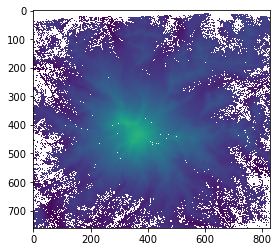

In [12]:
plt.imshow(aligned_data[2015])

### assign information on shared raster grid to variables for later use

In [13]:
epsg_32610 = meta[2015]['crs']
transform = meta[2015]['transform']
nrow, ncol = aligned_data[2015].shape
cellsize = transform[0]
extent = src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]  # extent for pyplot.imshow

### get the elevation of the summit
as noted in the original GeoHackWeek example, the elevation values in these rasters are relative to the WGS84 datum,
not a geoid model that approximate sea level. The geoid offset at Rainier is approximately 18.79 m, meaning that we have to add we have to add this to the values to get the [correct summit elevation of 14,411 ft](https://en.wikipedia.org/wiki/Mount_Rainier).

In [14]:
summit_ij = np.unravel_index(aligned_data[1970].argmax(), aligned_data[1970].shape)
summit_ij

(433, 367)

The corrected summit elevations being a little under 14,411 is a little unsatisfying, but one of the costs of downsampling the DEMs to a 30 m resolution to conserve space. At any rate, since we are interested in differences, the geoid offset doesn't matter for the remainder of our analysis.

In [15]:
elevation_offset = 18.79
(aligned_data[1970][summit_ij] + elevation_offset)/.3048  # in feet

14403.522994073983

### compute the elevation differences

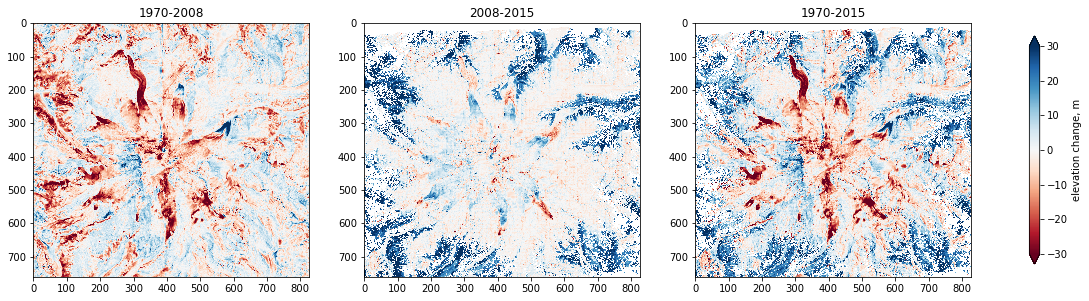

In [16]:
elevation_diffs = {}
elevation_diffs['1970-2008'] = aligned_data[2008] - aligned_data[1970]
elevation_diffs['2008-2015'] = aligned_data[2015] - aligned_data[2008]
elevation_diffs['1970-2015'] = aligned_data[2015] - aligned_data[1970]

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for i, (dates, diffs) in enumerate(elevation_diffs.items()):

    ax=axes.flat[i]
    im = ax.imshow(diffs, cmap='RdBu', vmin=-30, vmax=30)
    ax.set_title(dates)

fig.colorbar(im, ax=axes.flat, label='elevation change, m', shrink=0.6, extend='both')

### average rates

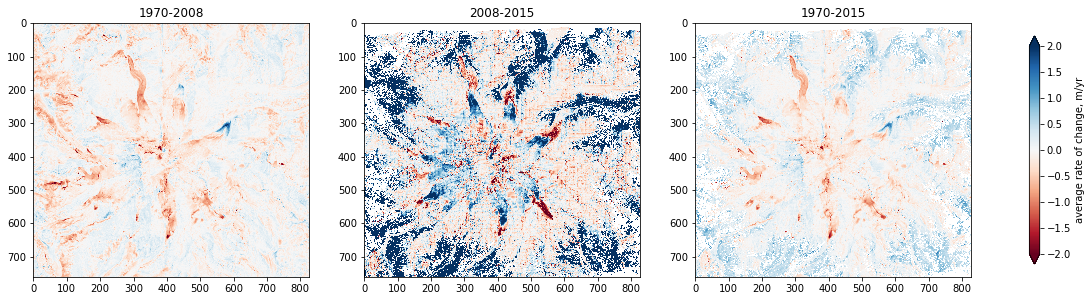

In [17]:
elevation_rates = {}
for dates, diffs in elevation_diffs.items():
    yr0, yr1 = map(int, dates.split('-'))
    annual_rate = diffs/(yr1-yr0)
    elevation_rates[dates] = annual_rate
    
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for i, (dates, rates) in enumerate(elevation_rates.items()):

    ax=axes.flat[i]
    im = ax.imshow(rates, cmap='RdBu', vmin=-2, vmax=2)
    ax.set_title(dates)

fig.colorbar(im, ax=axes.flat, label='average rate of change, m/yr', shrink=0.6, extend='both')

Notice the huge changes around the margins of the mountain. These are due to the 1970 and 2008 DEMs representing "bare ground", while the 2015 DEM includes trees.

### map the shapefile of glacier extents onto the same grid as the rasters
* first reproject the glacier features to the same crs as the rasters
* then make a column of unique identifiers (integers) for relating the features to raster pixels

In [18]:
glaciers = gp.read_file(glaciers_shapefile)
glaciers.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.14393,G238292E46809N,19709999,19949999,-121.70769,46.80930,2,4,0.126,2001,...,148,397,0,0,0,0,0,9,Williwakas Glacier WA,"POLYGON ((-121.70642 46.80792, -121.70650 46.8..."
1,RGI60-02.14394,G238275E46811N,19709999,19949999,-121.72504,46.81055,2,4,0.010,2207,...,222,-9,0,0,0,0,0,9,WA,"POLYGON ((-121.72552 46.80985, -121.72561 46.8..."
2,RGI60-02.14395,G238235E46811N,19709999,19949999,-121.76535,46.81088,2,4,0.010,2103,...,165,-9,0,0,0,0,0,9,WA,"POLYGON ((-121.76498 46.81006, -121.76511 46.8..."
3,RGI60-02.14396,G238243E46810N,19709999,19949999,-121.75702,46.80963,2,4,0.015,2186,...,153,182,0,0,0,0,0,9,WA,"POLYGON ((-121.75659 46.80885, -121.75663 46.8..."
4,RGI60-02.14397,G238302E46809N,19709999,19949999,-121.69756,46.80850,2,4,0.012,1990,...,125,160,0,0,0,0,0,9,WA,"POLYGON ((-121.69777 46.80903, -121.69760 46.8..."


In [19]:
glaciers.to_crs(epsg_32610, inplace=True)
glaciers['id'] = np.arange(1, len(glaciers) + 1)

### use rasterio to rasterize the glacier extents
* input is a collection of the (feature geometry, unique value) tuples
* output array shape and [Affine transform](https://rasterio.readthedocs.io/en/stable/topics/migrating-to-v1.html) instance

In [20]:
geoms = zip(glaciers.geometry, glaciers.id)
glacier_footprints = features.rasterize(geoms, out_shape=(nrow, ncol), transform=transform)

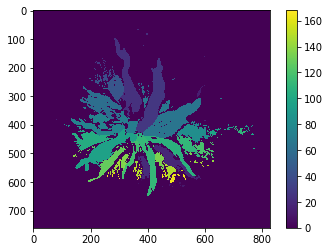

In [21]:
plt.imshow(glacier_footprints)
plt.colorbar()

### Clip the 1970-2015 raster to get an estimate of total volume change for all glaciers

In [22]:
masked_diffs = np.ma.masked_array(elevation_diffs['1970-2015'], mask=glacier_footprints == 0)

/Users/aleaf/anaconda3/envs/pyclass/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


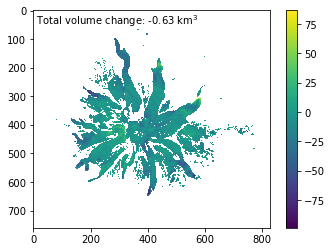

In [23]:
total_vol_change = masked_diffs.sum() * cellsize ** 2 / 1000**3

fig, ax = plt.subplots()
im = ax.imshow(masked_diffs)
ax.text(10, 50, "Total volume change: {:.2f} km$^3$".format(total_vol_change))
plt.colorbar(im)

### Get volume change by glacier, see if it relates to minimum elevation

In [24]:
vol_change = []
for n in glaciers.id.values:
    # compute total volume change
    change_1970_2015 = elevation_diffs['1970-2015'][glacier_footprints == n]
    vc = change_1970_2015.sum() * cellsize ** 2 / 1000**3
    vol_change.append(vc)
    
glaciers['d_vol_km3'] = vol_change

In [25]:
glaciers.sort_values(by='d_vol_km3', inplace=True)
glaciers.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,id,d_vol_km3
23,RGI60-02.14256,G238227E46901N,19709999,19949999,-121.77327,46.90137,2,4,8.004,1085,...,0,0,0,0,0,9,Carbon Glacier WA,"POLYGON ((591944.474 5199551.542, 591934.849 5...",24,-0.113276
111,RGI60-02.14336,G238252E46825N,19709999,19949999,-121.74768,46.82481,2,4,4.444,1425,...,0,0,0,0,0,1,Nisqually Glacier WA,"POLYGON ((595661.797 5185442.136, 595671.895 5...",112,-0.070763
26,RGI60-02.14259,G238261E46885N,19709999,19949999,-121.73878,46.88511,2,4,9.195,1437,...,0,0,0,0,0,9,Winthrop Glacier WA,"POLYGON ((596567.284 5191536.100, 596500.097 5...",27,-0.069127
64,RGI60-02.14297,G238286E46865N,19709999,19949999,-121.71401,46.86478,2,4,10.594,1605,...,0,0,0,0,0,1,Emmons Glacier WA,"POLYGON ((600717.130 5192154.864, 600689.098 5...",65,-0.063015
103,RGI60-02.14329,G238173E46848N,19709999,19949999,-121.82670,46.84820,2,4,4.017,1667,...,0,0,0,0,0,9,Puyallup Glacier WA,"POLYGON ((590132.877 5189587.640, 590162.377 5...",104,-0.050678


In [26]:
glaciers.columns

Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'geometry', 'id', 'd_vol_km3'],
      dtype='object')

Text(0.5, 0, 'Minimum elevation, in meters')

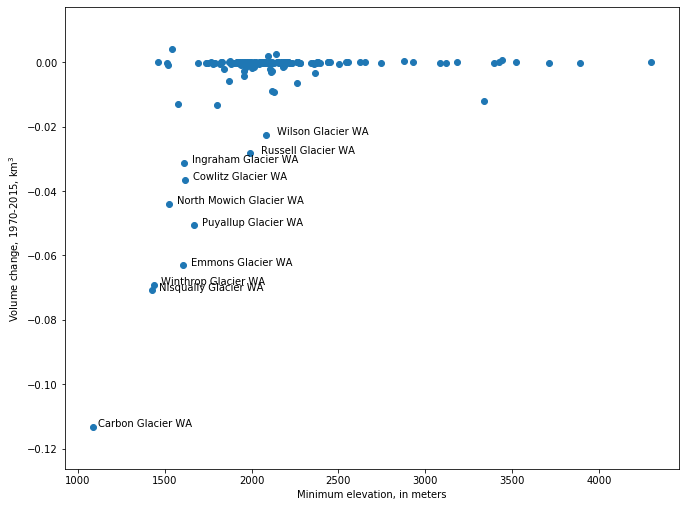

In [27]:
fig, ax = plt.subplots(figsize=(11, 8.5))
plt.scatter(glaciers.Zmin, glaciers.d_vol_km3)
for i, r in glaciers.head(10).iterrows():
    ax.text(r.Zmin * 1.03, r.d_vol_km3, r.Name)
ax.set_ylabel('Volume change, 1970-2015, km$^3$')
ax.set_xlabel('Minimum elevation, in meters')

In [28]:
594508.70, 5189550.08

(594508.7, 5189550.08)

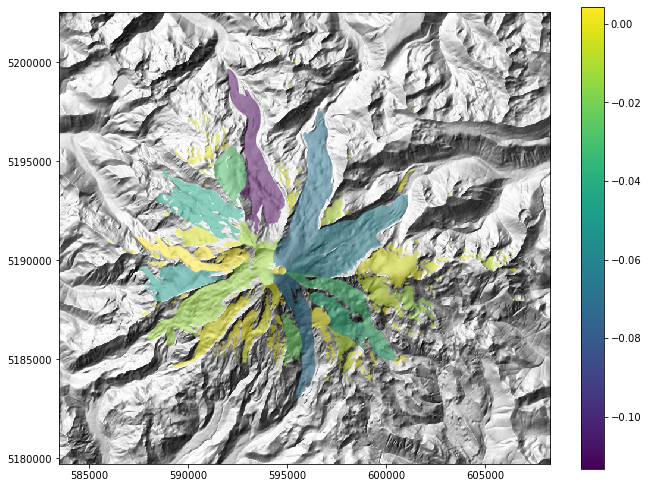

In [29]:
fig, ax = plt.subplots(figsize=(11, 8.5))

ax.imshow(ls.hillshade(aligned_data[1970], vert_exag=.1), cmap='gray', extent=extent)
ax = glaciers.plot('d_vol_km3', ax=ax, legend=True, zorder=10, alpha=0.5)

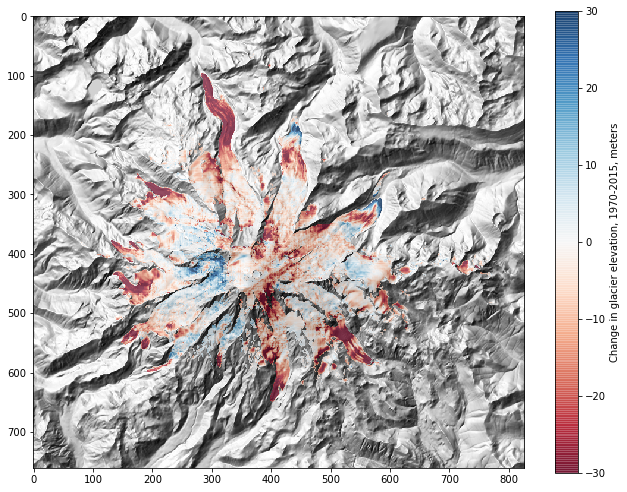

In [30]:
just_glaciers = np.ma.masked_array(elevation_diffs['1970-2015'], mask=glacier_footprints == 0)
fig, ax = plt.subplots(figsize=(11, 8.5))

ax.imshow(ls.hillshade(aligned_data[1970], vert_exag=0.1), cmap='gray', #extent=extent, 
          zorder=-1)
plt.imshow(just_glaciers, cmap='RdBu', vmin=-30, vmax=30, alpha=0.7)
plt.colorbar(label='Change in glacier elevation, 1970-2015, meters')

### Writing a raster: save out 1970-2015 elevation changes
To do this, we need to provide rasterio with the same information we got when we read the metadata for the aligned rasters (the elevation changes are on the same grid).
* first reset the mask to include all areas outside of the glacier footprints
* to simplify things, we can just copy the metadata dict we already have, and feed it to `rasterio.open` as keyword arguments by unpacking it (`**` notation)
    * let's add compression though to reduce the file size
* we can have rasterio write the mask as well
* Note that a raster can have more than one band. [This code (see `export_array` function)](https://github.com/aleaf/modflow-export/blob/master/mfexport/array_export.py) illustrates writing a 3D raster with a 3D mask to a single GeoTiff with multiple bands.

In [31]:
elevation_diffs['1970-2015'] = np.ma.masked_array(elevation_diffs['1970-2015'], mask=glacier_footprints == 0)

In [32]:
out_meta = meta[2015].copy()
out_meta['compress'] = 'lzw'
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 827,
 'height': 761,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(30.0, 0.0, 583464.253406,
        0.0, -30.0, 5202549.0989),
 'compress': 'lzw'}

In [33]:
el_change_outfile = 'data/gis/rainier_glaciers_1970-2015_el_change_m.tif'
with rasterio.open(el_change_outfile, 'w', **out_meta) as dest:
    
    # write the data to band 1
    dest.write(elevation_diffs['1970-2015'], 1)
    
    # write the mask as well
    dest.write_mask(~elevation_diffs['1970-2015'].mask)

### What if we want to reproject to a different CRS?

* We already have the information we need in memory, but it easiest to simply open a raster with the source grid and then read the metadata from the rasterio file instance
* We'll then feed that information to the `rasterio.warp.calculate_default_transform` function, which will return a new orientation (transform instance) and dimensions for the raster in the destination CRS.
* We'll use the new location information to update the metadata from the source grid
* The code below was taken from the [rasterio manual](https://rasterio.readthedocs.io/en/stable/topics/reproject.html) section on reprojection

In [34]:
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 827,
 'height': 761,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(30.0, 0.0, 583464.253406,
        0.0, -30.0, 5202549.0989),
 'compress': 'lzw'}

In [35]:
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'epsg:4269'
with rasterio.open(el_change_outfile) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # copy the source metadata
    kwargs = src.meta.copy()
    
    # update it with the new location information
    kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})
outfile = aligned_rasters[1970].replace('warp.tif', '4269.tif')
outfile

'data/gis/aligned-19700901_ned1_2003_adj_4269.tif'

#### Write the reprojected file with the information from above

In [36]:
with rasterio.open(outfile, 'w', **kwargs) as dst:
    reproject(
        source=aligned_data[1970],
        destination=rasterio.band(dst, 1),
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear)

## Zonal statistics with the `rasterstats` package
(another way to reduce raster data by polygon features, as we did above in summing the elevation differences by glacier)

In [37]:
from rasterstats import zonal_stats

In [38]:
help(zonal_stats)

Help on function zonal_stats in module rasterstats.main:

zonal_stats(*args, **kwargs)
    The primary zonal statistics entry point.
    
    All arguments are passed directly to ``gen_zonal_stats``.
    See its docstring for details.
    
    The only difference is that ``zonal_stats`` will
    return a list rather than a generator.



In [39]:
from rasterstats import gen_zonal_stats
help(gen_zonal_stats)

Help on function gen_zonal_stats in module rasterstats.main:

gen_zonal_stats(vectors, raster, layer=0, band=1, nodata=None, affine=None, stats=None, all_touched=False, categorical=False, category_map=None, add_stats=None, zone_func=None, raster_out=False, prefix=None, geojson_out=False, **kwargs)
    Zonal statistics of raster values aggregated to vector geometries.
    
    Parameters
    ----------
    vectors: path to an vector source or geo-like python objects
    
    raster: ndarray or path to a GDAL raster source
        If ndarray is passed, the ``affine`` kwarg is required.
    
    layer: int or string, optional
        If `vectors` is a path to an fiona source,
        specify the vector layer to use either by name or number.
        defaults to 0
    
    band: int, optional
        If `raster` is a GDAL source, the band number to use (counting from 1).
        defaults to 1.
    
    nodata: float, optional
        If `raster` is a GDAL source, this value overrides any NO

In [40]:
result = zonal_stats(glaciers.geometry.tolist(), el_change_outfile, stats=['mean'])

In [41]:
result

[{'mean': -14.183220468503494},
 {'mean': -15.954789595170455},
 {'mean': -7.5264308243508085},
 {'mean': -5.952325352801156},
 {'mean': -12.656410675151719},
 {'mean': -7.086173691860465},
 {'mean': -10.2095736629667},
 {'mean': -7.861405257035861},
 {'mean': -9.372398938152012},
 {'mean': -14.487558457801624},
 {'mean': -10.146442206776902},
 {'mean': -1.677891674426619},
 {'mean': -5.720126179942986},
 {'mean': -10.788493960432131},
 {'mean': -11.420169077822122},
 {'mean': -2.912341511961601},
 {'mean': -14.738457909058988},
 {'mean': -12.647637081399203},
 {'mean': -9.35452833299513},
 {'mean': -2.290050609691723},
 {'mean': -8.900850621665397},
 {'mean': -13.938433133638823},
 {'mean': -0.6004749814699694},
 {'mean': -1.141230245960076},
 {'mean': -12.572749546595983},
 {'mean': -4.440974571185405},
 {'mean': -61.40734375},
 {'mean': -15.334040912828947},
 {'mean': -4.373117107234589},
 {'mean': -12.34454983383862},
 {'mean': -5.232731066252056},
 {'mean': -3.3751079852764425},
 

In [42]:
glaciers['mean_el_change_m'] = [d['mean'] for d in result]

In [43]:
glaciers.sort_values(by='mean_el_change_m').head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Connect,Form,TermType,Surging,Linkages,Name,geometry,id,d_vol_km3,mean_el_change_m
94,RGI60-02.14579,G238389E46854N,19709999,-9999999,-121.61131,46.85395,2,4,0.023,2012,...,0,0,0,0,9,WA,"POLYGON ((605930.559 5189945.894, 605935.655 5...",95,-0.001382,-61.407344
111,RGI60-02.14336,G238252E46825N,19709999,19949999,-121.74768,46.82481,2,4,4.444,1425,...,0,0,0,0,1,Nisqually Glacier WA,"POLYGON ((595661.797 5185442.136, 595671.895 5...",112,-0.070763,-15.954790
87,RGI60-02.14319,G238159E46860N,19709999,19949999,-121.84114,46.86014,2,4,0.088,1970,...,0,0,0,0,9,WA,"POLYGON ((588067.776 5190318.647, 588049.276 5...",88,-0.001311,-15.334041
109,RGI60-02.14591,G238379E46854N,19709999,-9999999,-121.62056,46.85436,2,4,0.405,1867,...,0,0,0,0,9,Sarvant Glaciers WA,"POLYGON ((605395.071 5190219.959, 605402.479 5...",110,-0.005903,-14.738458
19,RGI60-02.18818,G238252E46825N,19709999,19949999,-121.74768,46.82481,2,4,1.551,2081,...,0,0,0,0,9,Wilson Glacier WA,"POLYGON ((594772.409 5186608.630, 594809.347 5...",20,-0.022479,-14.487558
